# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA 
from sklearn.impute import SimpleImputer 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from scipy import interp

%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [5]:
azdias.shape

(891221, 366)

In [6]:
customers.shape

(191652, 369)

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [9]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

**Feature Information**

In [10]:
# Laod DIAS Attributes
dias_attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])
del dias_attributes['Unnamed: 0']

# Drop NaN attribute
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isnull()]
dias_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [11]:
# dias_attributes Meanning counts
dias_attributes.Meaning.value_counts(dropna=False)

unknown                                                                             230
no transaction known                                                                 34
highest activity within the last 12 months                                           12
no transactions known                                                                10
numeric value (typically coded from 1-10)                                             3
numeric value                                                                         3
no Online-transactions within the last 12 months                                      3
single                                                                                2
typical low-income earners                                                            1
Work-Life-Balance                                                                     1
unknown / no main age detectable                                                      1
single low-income- and average e

In [12]:
# Find attribute with unknown Meaning
dias_attributes_unknown = dias_attributes[dias_attributes['Meaning'] == 'unknown']

# Keep only attribute of azdias
dias_attributes_unknown = dias_attributes_unknown[
    dias_attributes_unknown['Attribute'].isin(azdias.columns)]

# unknown_Meaning shape
dias_attributes_unknown.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown


In [13]:
# Laod DIAS Information level
dias_information_level = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
del dias_information_level['Unnamed: 0']
dias_information_level.columns = dias_information_level.columns.str.replace(' ', '_')
dias_information_level.head(5)


,Information_level,Attribute,Description,Additional_notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [14]:
dias_information_level.Information_level.value_counts(dropna=False)

NaN                   303
Community               1
PLZ8                    1
RR1_ID                  1
Microcell (RR4_ID)      1
Microcell (RR3_ID)      1
Building                1
Postcode                1
Person                  1
125m x 125m Grid        1
Household               1
Name: Information_level, dtype: int64

**Check what column with object type indicates** 

In [15]:
# Check object features
azdias_objects = azdias.select_dtypes(include='object')
azdias_objects.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [16]:
dias_information_level[dias_information_level.Attribute.isin(azdias_objects.columns)]

,Information_level,Attribute,Description,Additional_notes
83,NaN,OST_WEST_KZ,flag indicating the former GDR/FRG,NaN
85,Microcell (RR4_ID),CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,New German CAMEO Typology established together...
86,NaN,CAMEO_DEU_2015,CAMEO_4.0: specific group,NaN


In [17]:
azdias_objects.D19_LETZTER_KAUF_BRANCHE.value_counts(dropna=False)

NaN                       257113
D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN

In [18]:
azdias_objects.CAMEO_INTL_2015.value_counts(dropna=False)

NaN     98979
51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

**Comment:**
"EINGEFUEGT_AM" is a timestamp and hence we do not need it.
Also "D19_LETZTER_KAUF_BRANCHE" contain some variable names and there is no information regarding in attribute files. So lets drop these two columns.

LNR unique identifier for each row. Hence droping it too.

In [19]:
# Create List of columns to drop
columns_to_drop = ['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE']

In [20]:
id_azdias_LNR =  azdias['LNR']
azdias = azdias.drop('LNR', axis=1)

### Step 1: Data Preprocessing



###### 1.1 : Find columns with NaN values

In [21]:
# Count the number of nan values in each column
azdias_null = azdias.isnull().sum()
azdias_null_percent = azdias_null / len(azdias) * 100
azdias_null_percent.sort_values(ascending=False)

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LOTTO                      28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_KONSUMTYP                  28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
KBA05_MAXSEG                   14.959701
KBA05_MAXVORB                  14.959701
KBA05_MOD1                     14.959701
KBA05_SEG1                     14.959701
KBA05_MAXHERST                 14.959701
KBA05_MAXBJ                    14.959701
KBA05_MAXAH                    14.959701
KBA05_MOD2                     14.959701
KBA05_MOD3      

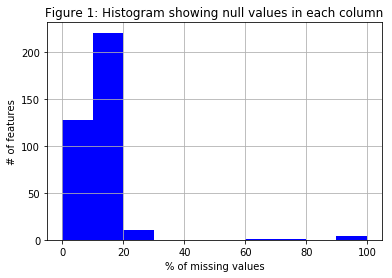

In [22]:
# Histogram of missing data in each column.
plt.hist(azdias_null_percent, bins=10, facecolor='b', alpha=1)
plt.xlabel('% of missing values')
plt.ylabel('# of features')
plt.title('Figure 1: Histogram showing null values in each column')
plt.grid(True)
plt.show()

In [23]:
missing_col_filtered = azdias_null_percent[azdias_null_percent>30]
print(missing_col_filtered)

ALTER_KIND1     90.904837
ALTER_KIND2     96.690047
ALTER_KIND3     99.307691
ALTER_KIND4     99.864792
EXTSEL992       73.399639
KK_KUNDENTYP    65.596749
dtype: float64


**Comment:**
We can see that the 6 columns identified above have missing values greather than 30 %.


In [24]:
null_columns = azdias.loc[:,list((azdias_null_percent>=30))].columns
#Add new column to drop in list
columns_to_drop.extend(null_columns) 
columns_to_drop 

['EINGEFUEGT_AM',
 'D19_LETZTER_KAUF_BRANCHE',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP']

In [25]:
# Most of the values from 6 columns are null and difficult to impute so lets delete this 6 columns 
print("azdias Shape before", azdias.shape)
azdias = azdias.drop(columns_to_drop, axis=1)
print("azdias Shape after", azdias.shape)

azdias Shape before (891221, 365)
azdias Shape after (891221, 357)


###### 1.2 : Find rows with NaN values

First we will see how many rows contain null/missing values. Then divide the missing data into two subsets to find pattern and to decide what to do with it. First set is for data points that are above some threshold for null values, and a second subset for points below that threshold.

In [26]:
# Number of rows which null values
print("Number of rows with NaN", sum(azdias.isnull().any(axis=1)))
row_nans = azdias.isnull().sum(axis=1)
print(row_nans.sort_values(ascending=False))

Number of rows with NaN 424497
55664     251
537799    251
350182    251
826869    251
373501    251
739769    250
23667     250
347712    250
716386    250
522174    250
629707    250
255742    250
5099      250
332962    250
140317    250
57866     250
475330    250
228624    250
765378    245
765415    245
851357    245
374119    245
374109    245
374098    245
373851    245
374073    245
374088    245
765375    245
374045    245
374037    245
         ... 
405146      0
405147      0
405148      0
405149      0
405152      0
405153      0
405155      0
405156      0
405157      0
405158      0
405159      0
754461      0
754460      0
754459      0
405166      0
405167      0
405168      0
405169      0
754457      0
405171      0
405172      0
405173      0
754455      0
405175      0
405177      0
405179      0
754451      0
405184      0
754449      0
445610      0
Length: 891221, dtype: int64


**Comment:**
424497 records out of total 891221 records have atleast 1 null record. Its 47% of the data.
so we will drop rows that have more than 40% of null data. Rows with more null values might affect machine learning algorithm.

In [27]:
print('number of rows in old dataset: ',azdias.shape[0])
# Drop row that contains more than 40% of nan values
azdias_40 = azdias[azdias.isnull().sum(axis=1) <= 40].reset_index(drop=True)
print('number of rows in new dataset: ',azdias_40.shape[0])

number of rows in old dataset:  891221
number of rows in new dataset:  751331


###### 1.3 : Remove correlated columns

In [28]:
# Create correlation matrix
corr_matrix = azdias_40.corr()

In [29]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
dias_attributes[dias_attributes['Attribute'].isin(to_drop)]

,Attribute,Description,Value,Meaning
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known
546,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12...,0,no transactions known
553,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24...,0,no transactions known
560,D19_VERSAND_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months
580,D19_VERSAND_ONLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months
590,D19_VERSAND_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months
929,KBA05_KRSHERST3,share of Ford/Opel (reffered to the county ave...,"-1, 9",unknown
1089,KBA05_SEG9,share of vans in the microcell,"-1, 9",unknown
1420,KBA13_HALTER_66,share of car owners over 66 within the PLZ8,-1,unknown
1462,KBA13_HERST_SONST,share of other cars within the PLZ8,-1,unknown


In [30]:
# Drop correlated features 
print(azdias_40.shape)
azdias_df = azdias_40.drop(to_drop, axis=1)
print(azdias_df.shape)

(751331, 357)
(751331, 336)


In [31]:
#columns_to_drop list will give us all the channels that have been deleted from Azdias
# need to be dropped from customers
columns_to_drop.extend(to_drop) 
drop_df = pd.DataFrame(columns_to_drop, columns =['column_names']) 
drop_df.to_csv('column_to be dropped.csv')

In [32]:
#Dropping Unique identifiers for customers
id_customers_LNR =  customers['LNR']
customers = customers.drop('LNR', axis=1)

In [33]:
print("customers Shape before", customers.shape)
customers_df = customers.drop(columns_to_drop, axis=1)
print("customers Shape after", customers_df.shape)

customers Shape before (191652, 368)
customers Shape after (191652, 339)


In [34]:
# Customer also have 3 extra columns of customers dataset.
customers_df = customers_df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)
print("customers Shape after", customers_df.shape)

customers Shape after (191652, 336)


#### 1.4 : encoding

In [35]:
#feature types, separate numeric columns from categorical

cols = azdias_df.columns
num_cols = azdias_df._get_numeric_data().columns
print('numeric columns: ',len(num_cols))
#get categorical columns
print('categorical columns: ',list(set(cols) - set(num_cols)))

numeric columns:  332
categorical columns:  ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ']


In [36]:
azdias_df[['CAMEO_INTL_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015','CAMEO_DEUG_2015']].head()

,CAMEO_INTL_2015,OST_WEST_KZ,CAMEO_DEU_2015,CAMEO_DEUG_2015
0,51,W,8A,8
1,24,W,4C,4
2,12,W,2A,2
3,43,W,6B,6
4,54,W,8C,8


###### 1.4.1 : encoding - OST_WEST_KZ

In [37]:
azdias_df.OST_WEST_KZ.value_counts(dropna=False)

W    591679
O    159652
Name: OST_WEST_KZ, dtype: int64

In [38]:
# Encode OST_WEST_KZ as dummy variable
azdias_df['OST_WEST_KZ'] = azdias_df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
azdias_df.OST_WEST_KZ.value_counts(dropna=False)

1    591679
2    159652
Name: OST_WEST_KZ, dtype: int64

In [39]:
#Applying same encoding operation on customers_df which we did on azdias_df
customers_df['OST_WEST_KZ'] = customers_df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
customers_df.OST_WEST_KZ.value_counts(dropna=False)

 1.0    130382
NaN      49927
 2.0     11343
Name: OST_WEST_KZ, dtype: int64

###### 1.4.2  : encoding -CAMEO_INTL_2015, CAMEO_DEU_2015, CAMEO_DEUG_2015

In [40]:
dias_attributes[dias_attributes['Attribute'].isin(['CAMEO_DEUG_2015','CAMEO_DEUG_2015', 'CAMEO_INTL_2015'])]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown


In [41]:
azdias_df.CAMEO_DEU_2015.value_counts(dropna=False)

6B     54368
8A     51517
4C     44224
2D     33024
7A     32939
3C     32772
3D     32495
8B     32227
8C     30425
4A     30311
9D     27919
9B     27072
9C     24418
7B     23533
9A     20203
2C     17825
8D     17220
6E     15721
5D     14265
6C     14206
2B     14134
2A     11933
1D     11485
1A     10215
5A      9786
5B      9723
5C      9092
7C      8762
4B      8308
4D      8115
6A      6501
3A      5899
6D      5851
3B      5716
9E      5629
6F      5126
7D      5104
4E      5034
1E      4799
7E      4431
5F      4090
1C      4048
1B      3846
5E      3415
NaN     3316
XX       289
Name: CAMEO_DEU_2015, dtype: int64

In [42]:
azdias_df.CAMEO_DEUG_2015.value_counts(dropna=False)

8      76227
9      60866
6      58851
4      55529
8.0    55162
2      44594
3      44523
9.0    44375
7      43192
6.0    42922
4.0    40463
3.0    32359
2.0    32322
7.0    31577
5      29369
5.0    21002
1      19936
1.0    14457
NaN     3316
X        289
Name: CAMEO_DEUG_2015, dtype: int64

In [43]:
azdias_df.CAMEO_INTL_2015.value_counts(dropna=False)

51      75961
51.0    54965
41      51362
24      49388
41.0    37337
24.0    35723
14      34151
43      31376
54      25574
14.0    24592
43.0    22992
25      21597
54.0    18717
22      17454
25.0    15932
45      14710
13      14087
55      13167
22.0    12857
52      11639
23      11613
45.0    10568
13.0    10262
34      10250
55.0     9682
31       9419
15       9415
52.0     8564
23.0     8310
44       8178
34.0     7430
12       6877
15.0     6869
31.0     6868
44.0     6028
35       5840
32       5693
33       5336
12.0     5056
35.0     4101
32.0     4030
33.0     3756
NaN      3316
XX        289
Name: CAMEO_INTL_2015, dtype: int64

In [44]:
def clean_object_type_columns(df):
    '''
    df = df[~df.CAMEO_INTL_2015.isin(['XX'])]
    df = df[~df.CAMEO_DEU_2015.isin(['XX'])]
    df = df[~df.CAMEO_DEUG_2015.isin(['X'])]
    '''
    df[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']].replace(['XX','X'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']].fillna(-1)
    
    df[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_DEU_2015','CAMEO_INTL_2015']].replace({-1: np.nan})
    
    df['CAMEO_INTL_2015_1s'] = df['CAMEO_INTL_2015'].astype(str).str[0]
    df['CAMEO_INTL_2015_10s'] = df['CAMEO_INTL_2015'].astype(str).str[1]
    
    df['CAMEO_INTL_2015_1s'] = df['CAMEO_INTL_2015_1s'].replace({'n': np.nan})
    df['CAMEO_INTL_2015_10s'] = df['CAMEO_INTL_2015_10s'].replace({'a': np.nan})
    
    df = df.drop('CAMEO_INTL_2015', axis=1)
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float).astype(object)
    
    return df

In [45]:
complete_azdias_df = clean_object_type_columns(azdias_df)
complete_azdias_df.shape

(751331, 337)

In [46]:
complete_customers_df = clean_object_type_columns(customers_df)
complete_customers_df.shape

(191652, 337)

In [47]:
# Check object features
complete_customers_df.select_dtypes(include='object').head(10)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015_1s,CAMEO_INTL_2015_10s
0,1A,1,1,3
1,NaN,NaN,NaN,NaN
2,5D,5,3,4
3,4C,4,2,4
4,7B,7,4,1
5,5D,5,3,4
6,3B,3,2,3
7,1D,1,1,5
8,9E,9,5,5
9,1D,1,1,5


In [48]:
# Get the dummies for object type attributes
complete_azdias_df = pd.get_dummies(complete_azdias_df)
complete_azdias_df.columns

Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'ARBEIT',
       ...
       'CAMEO_INTL_2015_1s_1', 'CAMEO_INTL_2015_1s_2', 'CAMEO_INTL_2015_1s_3',
       'CAMEO_INTL_2015_1s_4', 'CAMEO_INTL_2015_1s_5', 'CAMEO_INTL_2015_10s_1',
       'CAMEO_INTL_2015_10s_2', 'CAMEO_INTL_2015_10s_3',
       'CAMEO_INTL_2015_10s_4', 'CAMEO_INTL_2015_10s_5'],
      dtype='object', length=396)

In [49]:
[col for col in complete_azdias_df if col.startswith('CAMEO_DEUG_2015')]

['CAMEO_DEUG_2015_1.0',
 'CAMEO_DEUG_2015_2.0',
 'CAMEO_DEUG_2015_3.0',
 'CAMEO_DEUG_2015_4.0',
 'CAMEO_DEUG_2015_5.0',
 'CAMEO_DEUG_2015_6.0',
 'CAMEO_DEUG_2015_7.0',
 'CAMEO_DEUG_2015_8.0',
 'CAMEO_DEUG_2015_9.0']

In [50]:
# Get the dummies for object type attributes
complete_customers_df = pd.get_dummies(complete_customers_df)
complete_customers_df.columns

Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'ARBEIT',
       ...
       'CAMEO_INTL_2015_1s_1', 'CAMEO_INTL_2015_1s_2', 'CAMEO_INTL_2015_1s_3',
       'CAMEO_INTL_2015_1s_4', 'CAMEO_INTL_2015_1s_5', 'CAMEO_INTL_2015_10s_1',
       'CAMEO_INTL_2015_10s_2', 'CAMEO_INTL_2015_10s_3',
       'CAMEO_INTL_2015_10s_4', 'CAMEO_INTL_2015_10s_5'],
      dtype='object', length=396)

In [51]:
[col for col in complete_customers_df if col.startswith('CAMEO_DEUG_2015')]

['CAMEO_DEUG_2015_1.0',
 'CAMEO_DEUG_2015_2.0',
 'CAMEO_DEUG_2015_3.0',
 'CAMEO_DEUG_2015_4.0',
 'CAMEO_DEUG_2015_5.0',
 'CAMEO_DEUG_2015_6.0',
 'CAMEO_DEUG_2015_7.0',
 'CAMEO_DEUG_2015_8.0',
 'CAMEO_DEUG_2015_9.0']

###### 1.5 : Impute in place of NaN

In [52]:
sum(complete_azdias_df.isnull().any(axis=1))

284083

In [53]:
sum(complete_customers_df.isnull().any(axis=1))

72653

In [54]:
# impute NaN values using sklearn library  in general.
imputer_azdias = SimpleImputer()
imputer_azdias = imputer_azdias.fit(complete_azdias_df)
imputed_azdias = imputer_azdias.transform(complete_azdias_df)
imputed_azdias_df = pd.DataFrame(imputed_azdias)
sum(imputed_azdias_df.isnull().any(axis=1))

0

In [55]:
# impute NaN values using sklearn library in customer 
imputer_customers = SimpleImputer()
imputer_customers = imputer_customers.fit(complete_customers_df)
imputed_customer = imputer_customers.transform(complete_customers_df)
imputed_customers_df = pd.DataFrame(imputed_customer)
sum(imputed_customers_df.isnull().any(axis=1))

0

###### 1.6 : Scaling

In [56]:
# scale the azdias data
scale_azdias_obj = StandardScaler(copy=False)
scale_azdias_obj = scale_azdias_obj.fit(imputed_azdias_df)
imputed_azdias_df[imputed_azdias_df.columns] = scale_azdias_obj.transform(imputed_azdias_df)

In [57]:
# scale the customers data
scale_customers_obj = StandardScaler(copy=False)
scale_customers_obj = scale_customers_obj.fit(imputed_customers_df)
imputed_customers_df[imputed_customers_df.columns] = scale_customers_obj.transform(imputed_customers_df)

###### 1.6 : PCA

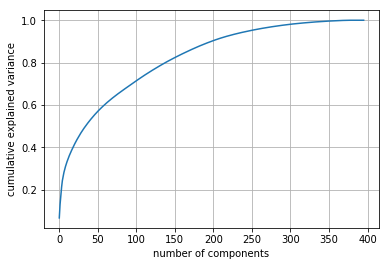

In [58]:
#We still have 397 dimensional data and we will  use Principal Component to reduce dimension.
pca = PCA().fit(imputed_azdias_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.savefig('PCA.png')

**Comment:** First 200 principal components shares the maximum amount of information, around 90%. So lets keep 200 componenets. Now we are down to 200 features from 397.

In [59]:
# PCA
pca = PCA(n_components=200).fit(imputed_azdias_df)
azdias_pca = pca.transform(imputed_azdias_df)
azdias_pca_df = pd.DataFrame(azdias_pca)
print(pca.explained_variance_ratio_.sum())
azdias_pca_df.head()

0.9011663725869348


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,5.009972,-2.231493,4.480828,-3.759361,-4.505915,0.938856,-2.106203,3.194973,0.035467,0.737277,...,0.071889,0.007611,1.290181,-0.659021,-0.836738,-0.061902,-0.783884,-0.381130,0.145800,-1.241728
1,-1.165552,-0.249042,0.558432,-3.243803,-3.470337,3.741415,-3.781008,-2.535808,0.651061,0.377288,...,0.541203,-0.842453,0.502385,0.170833,0.865725,-0.308472,-0.961559,0.482346,0.806038,-0.055043
2,-5.341985,2.395633,-3.907269,-1.296575,-3.661119,-0.831960,-0.996760,0.717837,-3.083647,-0.752044,...,1.061920,0.322334,0.810364,-0.215478,0.217535,-0.135490,0.181480,0.205875,-0.290086,0.462230
3,-3.793245,-0.554741,5.895283,-1.096008,8.070180,-3.185813,3.159848,-0.847659,-4.019527,6.777203,...,0.285641,0.162358,0.924700,0.443621,-0.181796,0.161411,-0.801956,-0.476950,0.303167,-0.933672
4,-2.631202,0.428082,-1.552604,-1.871140,-2.030557,1.099782,0.309687,1.462462,-0.373835,2.851802,...,0.549884,-0.274800,-0.062360,0.211655,0.444729,0.324206,-0.096099,-1.049462,-0.354888,-0.844876


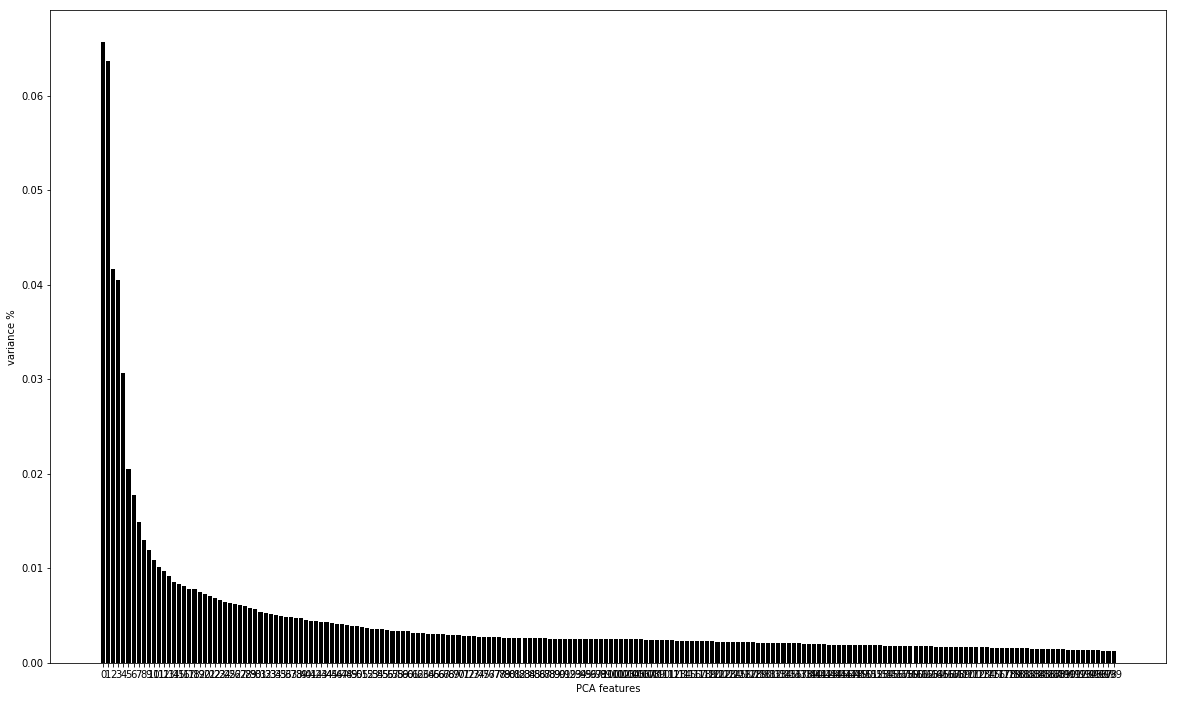

In [60]:
# Plot the explained variances
features = range(pca.n_components_)
plt.figure(figsize=(20, 12))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig('PCA_explained_variance.png')
# Save components to a DataFrame
PCA_components = pd.DataFrame(azdias_pca)

**Comment:** First 2 componenets, explain the majority of the variance in our data

In [61]:
# PCA Customers
pca_cust = PCA(n_components=200).fit(imputed_customers_df)
customers_pca = pca_cust.transform(imputed_customers_df)
customers_pca_df = pd.DataFrame(customers_pca)
customers_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,4.298492,-1.280569,5.638391,0.097246,-5.172806,-3.020796,-1.085453,-0.049677,-0.357069,-0.650446,...,-1.534085,-0.606481,-1.051142,1.373654,1.011860,1.317611,-0.091648,-0.298847,-0.267336,-0.608105
1,-0.015366,-0.073649,0.091137,0.137581,-0.526864,-0.345999,0.072671,-0.654642,-1.166868,-0.786692,...,-1.101935,0.245149,0.453238,-0.131757,-0.614997,-0.636348,-0.684819,-0.281434,-0.794932,0.044865
2,-3.673255,5.142002,-1.442144,2.488045,-3.886043,-4.701922,-3.794155,0.083931,2.336183,-1.680571,...,1.585711,0.905464,-0.025848,-0.514408,-0.391523,0.122403,0.746313,0.030146,-1.105691,-0.568362
3,2.932400,-3.208712,0.215296,0.491041,-4.112998,0.264043,4.894378,-1.088302,-0.205336,-3.358591,...,-0.068281,1.111532,-0.214126,0.059306,0.141720,-0.712158,-0.277711,0.115131,0.657815,-0.861310
4,2.396895,1.126736,-8.363738,-1.333450,7.700893,-2.194739,-4.319044,-0.430617,1.253320,0.591705,...,0.373326,0.169977,1.300149,-1.723648,0.752959,0.303684,0.689167,0.119001,0.637011,-1.289621


In [62]:
#What PCA component represent. Here is the example of PCA1
component = 0
pca_df = pd.DataFrame(pca.components_, columns=list(complete_azdias_df.columns))
pca_component = pd.DataFrame(pca_df.iloc[component])
print(pca_component.sort_values(component, ascending=False))

                                0
KBA13_ANTG3              0.139983
KBA13_ANTG4              0.137231
PLZ8_ANTG4               0.136293
KBA13_BAUMAX             0.136034
HH_EINKOMMEN_SCORE       0.128673
EWDICHTE                 0.121219
ORTSGR_KLS9              0.119837
CAMEO_INTL_2015_1s_5     0.112798
FINANZ_HAUSBAUER         0.105038
CAMEO_INTL_2015_10s_1    0.102787
VK_DISTANZ               0.099584
VK_DHT4A                 0.096950
PLZ8_ANTG2               0.096902
KBA05_ANTG4              0.095798
ARBEIT                   0.091737
D19_KONSUMTYP_MAX        0.091259
D19_GESAMT_DATUM         0.090797
VK_ZG11                  0.090200
KBA13_HALTER_30          0.089574
KBA13_HALTER_35          0.088250
CAMEO_DEUG_2015_9.0      0.086974
STRUKTURTYP              0.086391
ZABEOTYP                 0.084701
KBA05_BAUMAX             0.084610
ANZ_HAUSHALTE_AKTIV      0.083983
KONSUMZELLE              0.083652
RELAT_AB                 0.082717
D19_GESAMT_ONLINE_DATUM  0.081076
KBA05_ANTG3   

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Step 2: Clustering on Aazdias data

###### 2.1 Finding the number of clusters - with Elbow Criterion 

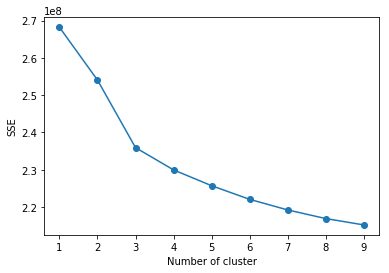

In [63]:
#Elbow Criterion for number of cluster selection or optimal (k)
sse = {}
silhouette = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_jobs=-1).fit(azdias_pca_df)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    #cluster_labels = kmeans.predict(azdias_pca_df)
    #silhouette[k] = silhouette_score(azdias_pca_df, cluster_labels)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),marker = 'o')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
#plt.savefig('Elbow_Criterion.png')

**Comment**: According to above Elbow criterion plot, sse does not decreased much after 4 th cluster.So lets use k=4.

###### 2.2 Build Cluster model

In [64]:
# Fit KMmeans model
kmeans = KMeans(n_clusters=4, n_jobs=-1)
model = kmeans.fit(azdias_pca_df)
prediction_azdias = model.predict(azdias_pca_df)

In [65]:
def plot_distribution(dist):
    ## Distribution of data point in each of these clusters obtained by k-means using 200 PCA components
    ax = sns.countplot(x = dist ,palette="viridis")
    sns.set(font_scale=1.5)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    fig = plt.gcf()
    fig.set_size_inches(10,5)
    ax.set_ylim()#30000)
    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(100*p.get_height()/len(dist)), (p.get_x()+ 0.2, p.get_height()+ 40))

    plt.title('Distribution of data in clusters obtained by K-means')
    plt.xlabel('Cluster Numbers')
    plt.ylabel('Frequency [%]')
    plt.show()

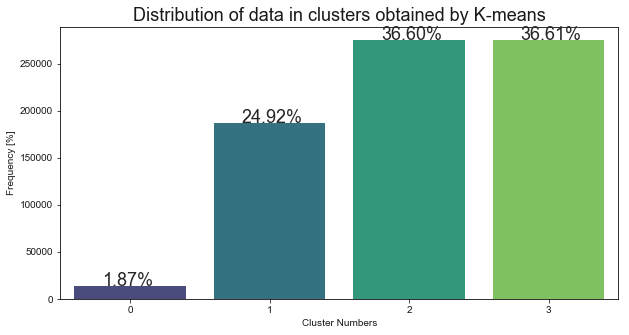

In [66]:
plot_distribution(prediction_azdias)

###### 2.3 Predictions using cluster model

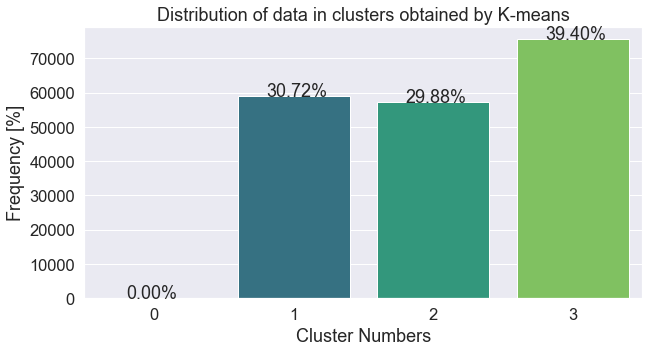

In [67]:
prediction_customers = model.predict(customers_pca_df)
plot_distribution(prediction_customers)

In [68]:
from pickle import dump
# save the imputer
dump(imputer_azdias, open('imputer.pkl', 'wb'))
# save the scaler
dump(scale_azdias_obj, open('scaler.pkl', 'wb'))
# save the pca
dump(azdias_pca, open('pca.pkl', 'wb'))
# save the model
dump(model, open('K-Means_model.pkl', 'wb'))

###### 2.4 Interpret the clusters

In [69]:
class_array_az = pd.Series(prediction_azdias).value_counts()
class_azdias_df = pd.DataFrame({'cluster': class_array_az.index,
                           '% of data': 100*class_array_az.values/len(prediction_azdias)})
class_azdias_df['data'] = 'General population'

class_array_cust = pd.Series(prediction_customers).value_counts()
class_customers_df = pd.DataFrame({'cluster': class_array_cust.index,
                              '% of data': 100*class_array_cust.values/len(prediction_customers)})
class_customers_df['data'] = 'Customer data'

In [70]:
class_customers_df

,cluster,% of data,data
0,3,39.397971,Customer data
1,1,30.722351,Customer data
2,2,29.879156,Customer data
3,0,0.000522,Customer data


In [71]:
class_azdias_df

,cluster,% of data,data
0,3,36.611161,General population
1,2,36.603973,General population
2,1,24.915783,General population
3,0,1.869083,General population


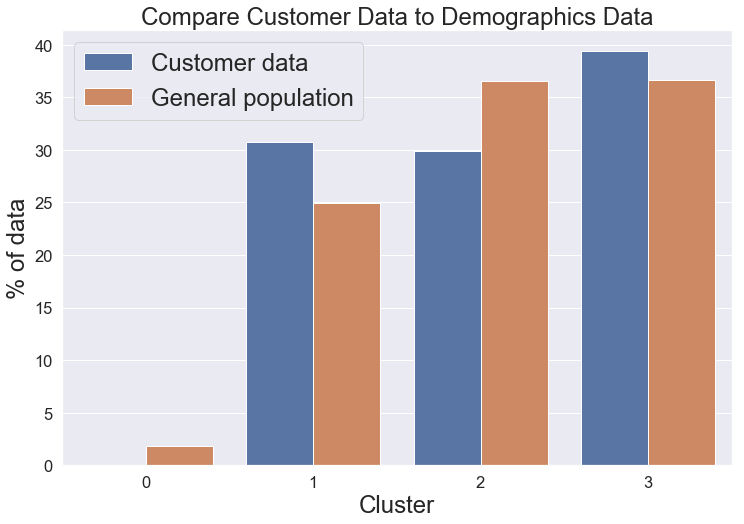

In [72]:
plt.figure(figsize=(12, 8))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([class_customers_df, class_azdias_df]))
plt.xlabel('Cluster', fontsize=24)
plt.ylabel('% of data', fontsize=24)
plt.title('Compare Customer Data to Demographics Data', fontsize=24)
plt.legend(fontsize=24)
plt.show()

**Comment: Almost 40 % percent of the customer data fit in the "cluster 3"  which contains 36% of general population data. 
Hence company can use this portion of population as a potential customers.
Opposite to this is the "Cluster 0", which can be excluded as % of customer is really low**

In [73]:
# Inverse transform of PCA for label:
def interpret_clusters(cluster_class):
    mask = np.isin(prediction_azdias, cluster_class)
    inverse_pca = pca.inverse_transform(azdias_pca[mask])
    inverse_scaler = scale_azdias_obj.inverse_transform(inverse_pca).round()
    clustered_azdias = pd.DataFrame(inverse_scaler, columns=complete_azdias_df.columns)
    return clustered_azdias

In [141]:
# Representation of population of cluster 3
actionable_class = [3]
result_df_3 = interpret_clusters(actionable_class)
result_df_3.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_INTL_2015_1s_1,CAMEO_INTL_2015_1s_2,CAMEO_INTL_2015_1s_3,CAMEO_INTL_2015_1s_4,CAMEO_INTL_2015_1s_5,CAMEO_INTL_2015_10s_1,CAMEO_INTL_2015_10s_2,CAMEO_INTL_2015_10s_3,CAMEO_INTL_2015_10s_4,CAMEO_INTL_2015_10s_5
0,-1.0,10.0,14.0,18.0,19.0,-0.0,0.0,2.0,0.0,3.0,...,0.0,0.0,0.0,-0.0,1.0,1.0,-0.0,0.0,0.0,-0.0
1,1.0,1.0,9.0,11.0,6.0,-0.0,0.0,1.0,0.0,5.0,...,0.0,0.0,0.0,-0.0,1.0,1.0,0.0,0.0,0.0,-0.0
2,-2.0,9.0,3.0,13.0,4.0,-0.0,-0.0,1.0,0.0,5.0,...,-0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,1.0
3,-1.0,8.0,2.0,15.0,11.0,0.0,0.0,1.0,-0.0,4.0,...,0.0,0.0,-0.0,-0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,-1.0,6.0,15.0,14.0,10.0,-0.0,1.0,2.0,-0.0,4.0,...,0.0,-0.0,0.0,0.0,1.0,1.0,0.0,-0.0,0.0,-0.0


In [142]:
# Representation of population of cluster 0
non_actionable_class = [0]
result_df_0 = interpret_clusters(non_actionable_class)
result_df_0.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_INTL_2015_1s_1,CAMEO_INTL_2015_1s_2,CAMEO_INTL_2015_1s_3,CAMEO_INTL_2015_1s_4,CAMEO_INTL_2015_1s_5,CAMEO_INTL_2015_10s_1,CAMEO_INTL_2015_10s_2,CAMEO_INTL_2015_10s_3,CAMEO_INTL_2015_10s_4,CAMEO_INTL_2015_10s_5
0,-1.0,3.0,17.0,18.0,13.0,-0.0,-0.0,1.0,0.0,3.0,...,-0.0,-0.0,-0.0,1.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0
1,0.0,10.0,-3.0,11.0,48.0,1.0,-0.0,1.0,0.0,3.0,...,-0.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,1.0
2,-1.0,2.0,17.0,15.0,7.0,-0.0,1.0,2.0,0.0,3.0,...,0.0,0.0,1.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0
3,-1.0,8.0,13.0,14.0,25.0,-0.0,-0.0,1.0,-0.0,4.0,...,0.0,0.0,0.0,1.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0
4,-1.0,6.0,19.0,19.0,44.0,0.0,0.0,1.0,-0.0,4.0,...,-0.0,-0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,0.0,0.0


In [143]:
result_df_0['label'] = 0
result_df_3['label'] = 3

In [144]:
#merge only two clusters to find out diffrences 
result = result_df_0.append(result_df_3)
desc = result.groupby('label').mean()

In [145]:
desc_temp = desc[desc.columns[10:25]] 
desc_temp

,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL
label,,,,,,,,,,,,,,,
0,3.730542,3.223599,3.996724,2.958983,2.987182,3.497971,3.660471,3.523535,3.794916,0.047995,0.080467,9.710746,0.401054,0.259631,0.031902
3,3.243908,3.691691,3.317642,3.674240,3.680061,2.728757,2.969593,2.741285,2.987883,0.073835,0.132308,9.492953,0.760625,0.511028,0.033660


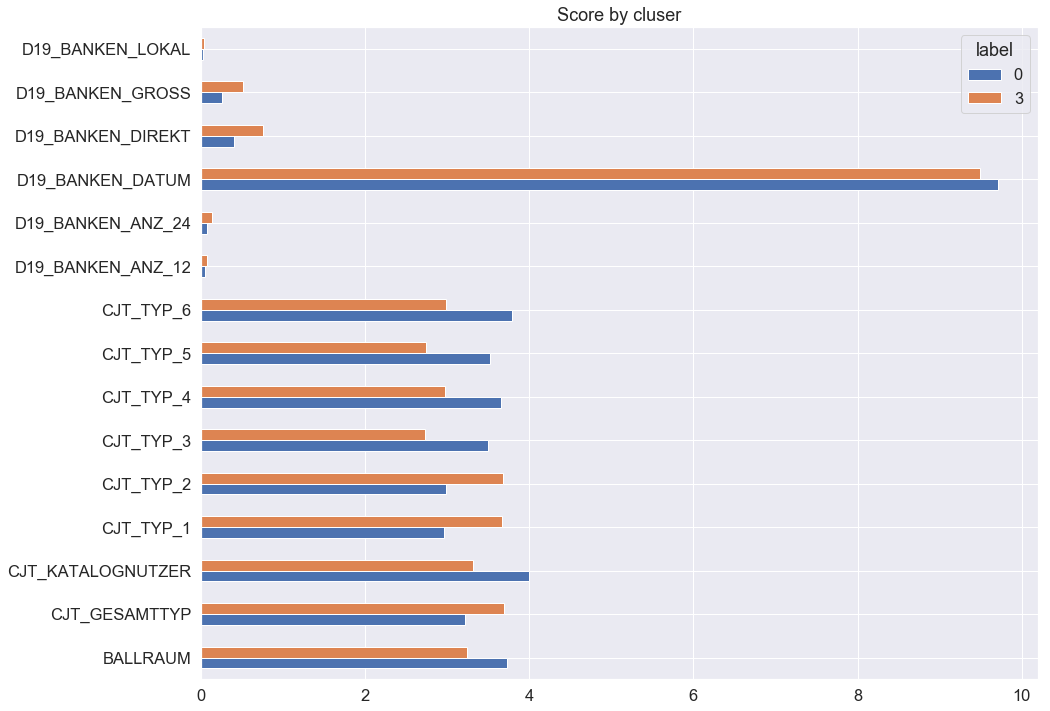

In [146]:
#plot mean values of some features per cluster
plt.rcParams['figure.figsize'] = [15,12]#[25,150]
ax =  desc_temp.T.plot.barh(width=0.5, title= 'Score by cluser')
plt.savefig('Scores_Cluster.png')

**Comment:** Above graph shows few features, which helps to identify where new person of a population fits, either in 0 or 3 cluster.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [80]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


### Step 3: Classification of mailout data

##### 3.1 Clean up the data

In [81]:
#Dropping Unique identifiers for mailout data
id_mailout_train_LNR =  mailout_train['LNR']
mailout_train = mailout_train.drop('LNR', axis=1)

In [82]:
#Clean train data- we are deleting the features from mailout dataset 
#which have removed from first two datasets as well.  
print("mailout train Shape before", mailout_train.shape)
mailout_train_df = mailout_train.drop(columns_to_drop, axis=1)
print("mailout train shape after", mailout_train_df.shape)

mailout train Shape before (42962, 366)
mailout train shape after (42962, 337)


In [83]:
# Check object features
mailout_objects = mailout_train_df.select_dtypes(include='object')
mailout_objects.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,5D,5,34,W
1,5B,5,32,W
2,2D,2,14,O
3,2D,2,14,W
4,7B,7,41,W


In [84]:
# Encode OST_WEST_KZ as dummy variable
mailout_train_df['OST_WEST_KZ'] = mailout_train_df['OST_WEST_KZ'].map({'W': 1, 'O': 2})

#Create dummy variables for object types
mailout_train_df = clean_object_type_columns(mailout_train_df)

# Get the dummies for object type attributes
complete_mailout_train_df = pd.get_dummies(mailout_train_df)
complete_mailout_train_df.shape

(42962, 397)

##### 3.2 Separate features and labels

In [85]:
#Distribution of response classes
complete_mailout_train_df.RESPONSE.value_counts(dropna=False)

0    42430
1      532
Name: RESPONSE, dtype: int64

In [86]:
# Shuffle dataframe before separating label
complete_mailout_train_df = shuffle(complete_mailout_train_df)

In [87]:
# separate labels from features
X = complete_mailout_train_df.drop('RESPONSE',axis=1)
y = complete_mailout_train_df['RESPONSE']

##### 3.3 Impute NaN and scale

In [88]:
# Number of rows which null values
print("Number of rows with NaN", sum(X.isnull().any(axis=1)))
row_nans = X.isnull().sum(axis=1)
print(row_nans.sort_values(ascending=False))

Number of rows with NaN 13571
30719    230
40927    230
34386    230
20828    230
4560     230
3519     230
22551    230
20830    230
19193    230
20202    230
37755    230
20234    230
32365    230
7967     230
9856     230
4693     230
5040     230
38232    230
15646    230
28966    230
27102    230
5560     230
37236    230
25078    230
33739    230
30733    230
39780    230
32765    230
9086     230
37143    230
        ... 
32723      0
35527      0
3479       0
33453      0
14365      0
9084       0
20557      0
3461       0
36469      0
16471      0
12517      0
39355      0
15619      0
21098      0
42048      0
41085      0
12944      0
26174      0
11768      0
33587      0
5191       0
13080      0
25607      0
37625      0
29772      0
40512      0
11605      0
25641      0
676        0
35143      0
Length: 42962, dtype: int64


**Comment**: Around 30% of the have atleast one NaN, so lets impute these NaN values.

In [89]:
# impute NaN values with imputer object of general population
imputed_X = imputer_azdias.transform(X)
imputed_X_df = pd.DataFrame(imputed_X)
sum(imputed_X_df.isnull().any(axis=1))

0

In [90]:
# Scale the features
imputed_X_df[imputed_X_df.columns] = scale_azdias_obj.transform(imputed_X_df)

In [91]:
#For training on google colab
save_imputed_X_df = imputed_X_df.copy()
save_imputed_X_df['y'] = y
save_imputed_X_df.to_csv('training_data.csv')

##### 3.4 Modeling

**3.4.1 Subsampling:** As data is imbalanced, I am creating one simple model with Random Under-Sampling/subsampling method.**

In [92]:
# subsampled data- amount of 1 class is 532 rows 
df_1 = save_imputed_X_df.loc[save_imputed_X_df['y'] == 1]
df_0 = save_imputed_X_df.loc[save_imputed_X_df['y'] == 0][:532]
normal_distributed_df = pd.concat([df_0, df_1])
#Distribution of response classes in sumsample
normal_distributed_df.y.value_counts(dropna=False)

1    532
0    532
Name: y, dtype: int64

In [93]:
# separate labels from features
X_subsample = normal_distributed_df.drop('y',axis=1)
y_subsample = normal_distributed_df['y']

In [94]:
X_sub = X_subsample.as_matrix()#to_numpy()
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_subsample, test_size=0.33, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [95]:
#Base Model with subsampled data
clf = RandomForestRegressor().fit(x_train_sub, y_train_sub)
train_sub_pred = clf.predict(x_train_sub)
test_sub_pred = clf.predict(x_test_sub)

In [96]:
print("ROC AUC, Train:", roc_auc_score(y_train_sub, train_sub_pred),
      " Test:", roc_auc_score(y_test_sub, test_sub_pred))

ROC AUC, Train: 0.9904385930283053  Test: 0.48388088687489883


**Comment:** Subsample causing overfitting and we are loosing lots of data. So keeping original dataset and experimenting with diffrent algorithms.



**3.4.2 Checking Algorithms and respective learning curves**

In [97]:
plt.rcParams['figure.figsize'] = [10,8]

In [98]:
def plot_learning_curve(name, estimator):
    train_sizes = np.linspace(.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, imputed_X_df, y, cv=5, scoring='roc_auc', n_jobs=-1, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    fig = plt.figure()
    plt.grid()
    plt.title(name)
    plt.xlabel("Training examples")
    plt.ylabel("Auc score")

    plt.plot(train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()
    plt.savefig(name + '.png')

**3.4.2.1 GridSearch for LogisticRegression:** Here is the gridsearch to find parameters for LogisticRegression

In [99]:
# Logistic Regression 
grid_logistic_reg = GridSearchCV(LogisticRegression(), 
                            {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
grid_logistic_reg.fit(imputed_X_df, y)
print(grid_logistic_reg.best_estimator_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


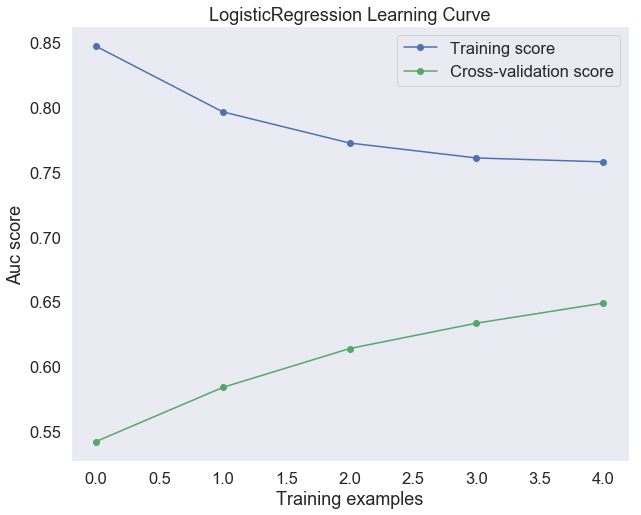

<Figure size 720x576 with 0 Axes>

In [100]:
# pass the the best parameters to curve plot
plot_learning_curve("LogisticRegression Learning Curve", grid_logistic_reg.best_estimator_)

In [101]:
log_reg_pred = cross_val_predict(grid_logistic_reg.best_estimator_, imputed_X_df, y, cv=5, method="decision_function")
roc_auc_score(y, log_reg_pred)

0.6457862707085886

**3.4.2.2 GridSearch for RandomForestRegressor:** Here is the gridsearch to find parameters for ensemble method called randomForestRegressor:

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  9.6min finished


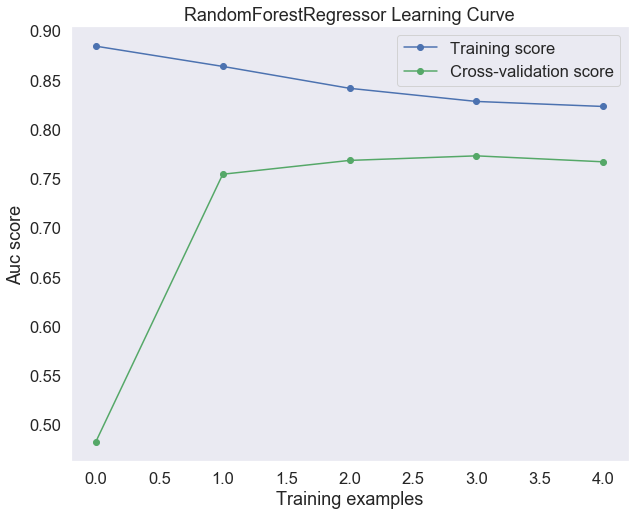

<Figure size 720x576 with 0 Axes>

In [102]:
# we will select 'roc_auc' scoring as dataset is imbalanced
gsc = GridSearchCV(estimator=RandomForestRegressor(),
    param_grid={
        'max_depth': (3, 5, 7),
        'n_estimators': (10, 70, 200),
    },
    cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

grid_rfr = gsc.fit(imputed_X_df, y)
best_params = grid_rfr.best_params_

grid_rfr.best_estimator_
plot_learning_curve("RandomForestRegressor Learning Curve", grid_rfr.best_estimator_)

In [103]:
#print(best_params)
#{'max_depth': 3, 'n_estimators': 200}
random_regressor_pred = cross_val_predict(grid_rfr.best_estimator_, imputed_X_df, y, cv=5)
roc_auc_score(y, random_regressor_pred)

0.7620244046363848

**3.4.2.3 GridSearch for XGBRegressor:** Here is the gridsearch to find parameters for XGBRegressor

In [104]:
from xgboost import XGBRegressor
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold

In [105]:
# Various hyper-parameters to tune
xgb_reg = XGBRegressor()
parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [.03, 0.04, 0.05],
            'scale_pos_weight':[1, 10, 25, 50, 75], 
              'n_estimators': [70, 100,300]}

grid_xgb_reg = GridSearchCV(xgb_reg,
                        parameters,
                        cv = 5,
                        scoring='roc_auc',
                        n_jobs = 5,
                        verbose=True)

grid_xgb_reg.fit(imputed_X_df, y)

print(grid_xgb_reg.best_score_)
print(grid_xgb_reg.best_params_)

# report the best configuration
print("Best: %f using %s" % (grid_xgb_reg.best_score_, grid_xgb_reg.best_params_))

# report all configurations
means = grid_xgb_reg.cv_results_['mean_test_score']
stds = grid_xgb_reg.cv_results_['std_test_score']
params = grid_xgb_reg.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#0.7756945160110197
#{'learning_rate': 0.05, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 1}
#Best: 0.775695 using {'learning_rate': 0.05, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 1}

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  9.5min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 79.8min
[Parallel(n_jobs=5)]: Done 225 out of 225 | elapsed: 104.5min finished


0.769769542252775
{'learning_rate': 0.05, 'n_estimators': 70, 'objective': 'binary:logistic', 'scale_pos_weight': 10}
Best: 0.769770 using {'learning_rate': 0.05, 'n_estimators': 70, 'objective': 'binary:logistic', 'scale_pos_weight': 10}
0.765707 (0.026734) with: {'learning_rate': 0.03, 'n_estimators': 70, 'objective': 'binary:logistic', 'scale_pos_weight': 1}
0.763779 (0.026329) with: {'learning_rate': 0.03, 'n_estimators': 70, 'objective': 'binary:logistic', 'scale_pos_weight': 10}
0.760206 (0.022939) with: {'learning_rate': 0.03, 'n_estimators': 70, 'objective': 'binary:logistic', 'scale_pos_weight': 25}
0.752627 (0.015678) with: {'learning_rate': 0.03, 'n_estimators': 70, 'objective': 'binary:logistic', 'scale_pos_weight': 50}
0.749924 (0.012893) with: {'learning_rate': 0.03, 'n_estimators': 70, 'objective': 'binary:logistic', 'scale_pos_weight': 75}
0.763111 (0.023555) with: {'learning_rate': 0.03, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 1}
0.7676

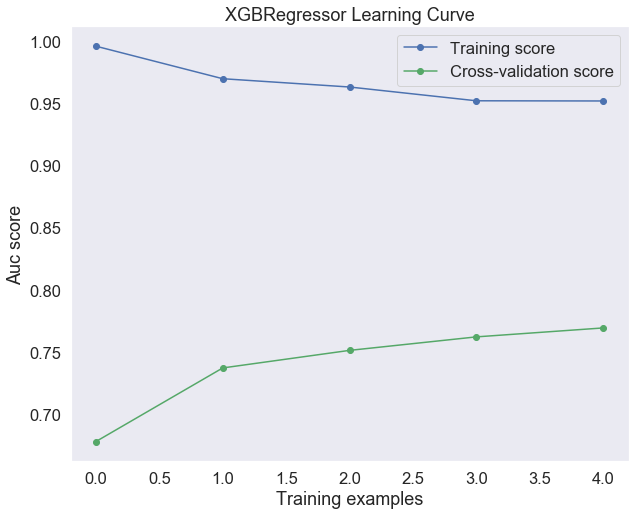

<Figure size 720x576 with 0 Axes>

In [106]:
plot_learning_curve("XGBRegressor Learning Curve", grid_xgb_reg.best_estimator_)

In [107]:
#Best: 0.769770 using {'learning_rate': 0.05, 'n_estimators': 70, 'objective': 'binary:logistic', 'scale_pos_weight': 10}

xgb_reg_pred = cross_val_predict(grid_xgb_reg.best_estimator_, imputed_X_df, y, cv=5)
roc_auc_score(y, xgb_reg_pred)

0.7649967925942596

**Comment:** Learning curve or validation score is decreasing for Random forest regressor when we increase number of examples. However XGB regressor score is not decreasing and AUC score looks good than Logistic regression. So best estimator for final prediction will be XGBRegressor. 

**3.4.5 ROC Curve Analysis**

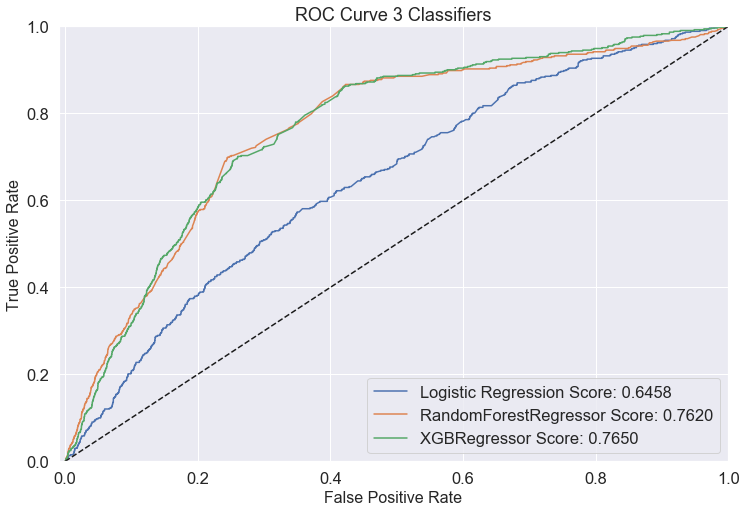

In [108]:
plt.figure(figsize=(12,8))
plt.title('ROC Curve 3 Classifiers', fontsize=18)
log_fpr, log_tpr, log_thresold = roc_curve(y, log_reg_pred)
rfr_fpr, rfr_tpr, rfr_thresold = roc_curve(y, random_regressor_pred)
xgb_fpr, xgb_tpr, xgb_thresold = roc_curve(y, xgb_reg_pred)
plt.plot(log_fpr, log_tpr, label='Logistic Regression Score: {:.4f}'.format(roc_auc_score(y, log_reg_pred)))
plt.plot(rfr_fpr, rfr_tpr, label='RandomForestRegressor Score: {:.4f}'.format(roc_auc_score(y, random_regressor_pred)))
plt.plot(xgb_fpr, xgb_tpr, label='XGBRegressor Score: {:.4f}'.format(roc_auc_score(y, xgb_reg_pred)))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend()
plt.show()

#### 3.5 Fit final model using best estimator parameters

In [136]:
xgb = XGBRegressor(learning_rate=0.05, n_estimator=70, objective='binary:logistic', scale_pos_weight=10)
xgb.fit(imputed_X_df, y)

[05:00:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimator=70, n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=10, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [140]:
from pickle import dump
# save the model
dump(xgb, open('XGBRegressor_model.pkl', 'wb'))

**Comment:** Final model is ready. Lets use it for predictions in next part

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [123]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### 4.1 Preprocessing

In [124]:
#Dropping Unique identifiers for customers
id_mailout_test_LNR =  mailout_test['LNR']
mailout_test = mailout_test.drop('LNR', axis=1)

In [125]:
#Clean test data- we are deleting the features from mailout dataset 
#which have removed from first two datasets as well.  
print("mailout train Shape before", mailout_test.shape)
mailout_test_df = mailout_test.drop(columns_to_drop, axis=1)
print("mailout train shape after", mailout_test.shape)

mailout train Shape before (42833, 365)
mailout train shape after (42833, 365)


In [126]:
# Encode OST_WEST_KZ as dummy variable
mailout_test_df['OST_WEST_KZ'] = mailout_test_df['OST_WEST_KZ'].map({'W': 1, 'O': 2})

#Create dummy variables for object types
mailout_test_df = clean_object_type_columns(mailout_test_df)

# Get the dummies for object type attributes
complete_mailout_test_df = pd.get_dummies(mailout_test_df)
complete_mailout_test_df.shape

(42833, 396)

In [127]:
# Number of rows which null values
print("Number of rows with NaN", sum(complete_mailout_test_df.isnull().any(axis=1)))
row_nans = complete_mailout_test_df.isnull().sum(axis=1)
print(row_nans.sort_values(ascending=False))

Number of rows with NaN 13551
29637    233
17393    230
9861     230
28342    230
3179     230
38139    230
9840     230
28338    230
38144    230
28332    230
28328    230
28323    230
9856     230
9864     230
38165    230
28297    230
38153    230
9872     230
3169     230
28288    230
38158    230
28286    230
9877     230
38162    230
38136    230
3181     230
28343    230
28348    230
28427    230
9780     230
        ... 
25759      0
25760      0
25761      0
25763      0
25764      0
25765      0
25767      0
25768      0
25769      0
25771      0
25773      0
25774      0
25775      0
25776      0
25777      0
25779      0
25780      0
25782      0
25783      0
25784      0
25789      0
25790      0
25791      0
25792      0
25793      0
25795      0
25796      0
25798      0
25799      0
0          0
Length: 42833, dtype: int64


In [128]:
# impute NaN values with imputer object of general population
imputed_test = imputer_azdias.transform(complete_mailout_test_df)
imputed_test_df = pd.DataFrame(imputed_test)
sum(imputed_test_df.isnull().any(axis=1))

0

In [129]:
# Scale the features
imputed_test_df[imputed_test_df.columns] = scale_azdias_obj.transform(imputed_test_df)

In [137]:
predictions = xgb.predict(imputed_test_df)

In [138]:
submission = pd.DataFrame(predictions, index = id_mailout_test_LNR.astype(int),columns=["RESPONSE"])
submission.head()

,RESPONSE
LNR,
1754,0.255372
1770,0.181949
1465,0.024009
1470,0.008532
1478,0.062922


In [139]:
# Kaggle submission
submission.to_csv('submission.csv')